In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import warnings

warnings.filterwarnings("ignore")


In [3]:
class EyeDiseaseDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def data_paths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            fold_path = os.path.join(self.data_dir, fold)
            filelist = os.listdir(fold_path)
            for file in filelist:
                fpath = os.path.join(fold_path, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def data_frame(self, files, labels):
        fseries = pd.Series(files, name='filepaths')
        lseries = pd.Series(labels, name='labels')
        return pd.concat([fseries, lseries], axis=1)

    def split_(self):
        files, labels = self.data_paths()
        df = self.data_frame(files, labels)
        strat = df['labels']
        train_data, dummy_data = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummy_data['labels']
        valid_data, test_data = train_test_split(dummy_data, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return train_data, valid_data, test_data

    # def train_test_split(self, df, test_size=0.2, random_state=42):
    #     return train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['labels'])

In [4]:

data_dir = '/content/drive/My Drive/Colab Notebooks/data/dataset_resized'

In [5]:
data_split = EyeDiseaseDataset(data_dir)
train_data, valid_data, test_data = data_split.split_()

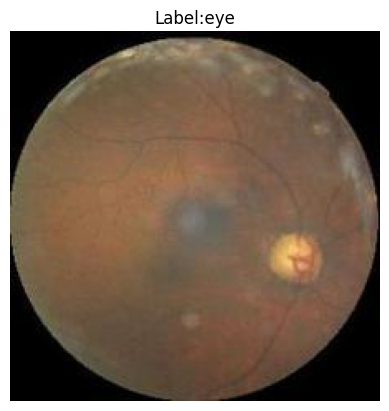

In [6]:

def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']

    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

In [7]:
class EyeDiseaseDatasetPyTorch(Dataset):
    def __init__(self, dataframe, label_map, transform=None):
    # def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 1]
        label = self.label_map[label]  # Convert label to integer index

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Create a label map
unique_labels = train_data['labels'].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# Print the label map to verify
print(label_map)

{'not_eye': 0, 'eye': 1}


In [9]:
def augment_data(train_df, valid_df, test_df, label_map, batch_size=32):
# def augment_data(train_df, valid_df, test_df, batch_size=16):
    # img_size = (224, 224)

    train_transform = transforms.Compose([
        # transforms.Resize(img_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_test_transform = transforms.Compose([
        # transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = EyeDiseaseDatasetPyTorch(train_df, label_map, transform=train_transform)
    valid_dataset = EyeDiseaseDatasetPyTorch(valid_df, label_map, transform=valid_test_transform)
    test_dataset = EyeDiseaseDatasetPyTorch(test_df, label_map, transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Shape of augmented training images:", next(iter(train_loader))[0].shape)
    print("Shape of validation images:", next(iter(valid_loader))[0].shape)
    print("Shape of test images:", next(iter(test_loader))[0].shape)

    return train_loader, valid_loader, test_loader

In [10]:
train_loader, valid_loader, test_loader = augment_data(train_data, valid_data, test_data, label_map)

Shape of augmented training images: torch.Size([32, 3, 224, 224])
Shape of validation images: torch.Size([32, 3, 224, 224])
Shape of test images: torch.Size([32, 3, 224, 224])


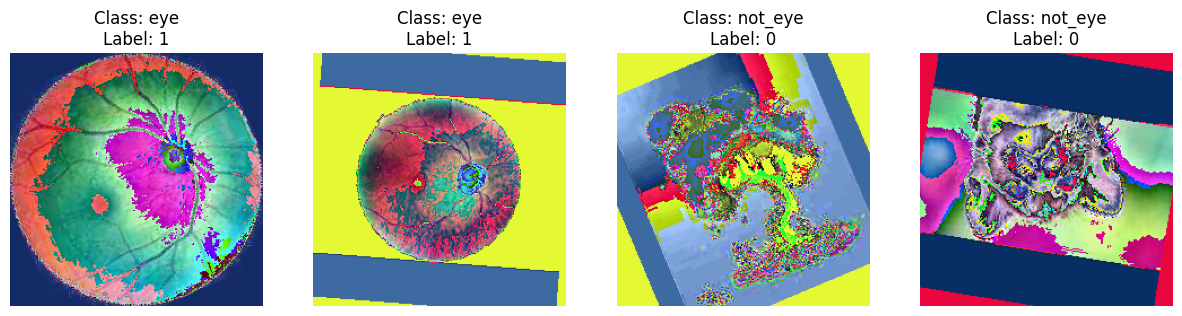

In [11]:
# Assuming label_map is available
# label_map = {'class_name_1': 0, 'class_name_2': 1, ..., 'class_name_n': n-1}
reverse_label_map = {v: k for k, v in label_map.items()}

def show_images(loader, batch_size=32):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy()

    fig, axes = plt.subplots(1, min(batch_size, 4), figsize=(15, 15))
    for idx in range(min(batch_size, 4)):
        ax = axes[idx]
        img = np.transpose(images[idx], (1, 2, 0)) * 255  # Scale images to [0, 255]
        img = img.astype(np.uint8)  # Convert to unsigned 8-bit integer type
        label_idx = labels[idx].item()
        class_name = reverse_label_map[label_idx]
        ax.imshow(img)
        ax.set_title(f'Class: {class_name}\nLabel: {label_idx}')
        ax.axis('off')
    plt.show()

show_images(train_loader)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        self.base_model.classifier[6] = nn.Linear(self.base_model.classifier[6].in_features, num_classes)

        # Freeze all layers except the final fully connected layer
        for name, param in self.base_model.named_parameters():
            if "classifier.6" in name:  # Unfreeze the final fully connected layer
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)
        y_pred = nn.ReLU()(x)
        return y_pred

Using device: cuda


In [13]:
import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [14]:
num_classes = len(train_data['labels'].unique())
model = VGG16(num_classes).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
es = EarlyStopping()

num_epochs = 50
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 173MB/s]


VGG16(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [15]:


# Instantiate EarlyStopping
early_stopping = EarlyStopping(patience=5, min_delta=0, restore_best_weights=True)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}%")

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0


    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    val_accuracy = 100 * correct_valid / total_valid

    history['val_loss'].append(avg_valid_loss)
    history['val_acc'].append(val_accuracy)

    print(f'Validation Loss: {avg_valid_loss}, Validation Accuracy: {val_accuracy}%')

    # Call early stopping
    if early_stopping(model, avg_valid_loss):
        print("Early stopping")
        break

Epoch 1/75, Train Loss: 0.22905669223568212, Train Accuracy: 94.90145672664953%
Validation Loss: 0.10614967867732047, Validation Accuracy: 98.97260273972603%
Epoch 2/75, Train Loss: 0.06734886369986894, Train Accuracy: 98.62896315338475%
Validation Loss: 0.05700687058269978, Validation Accuracy: 99.65753424657534%
Epoch 3/75, Train Loss: 0.042000670738722365, Train Accuracy: 99.40017137960582%
Validation Loss: 0.04107406996190548, Validation Accuracy: 99.65753424657534%
Epoch 4/75, Train Loss: 0.028973112214509756, Train Accuracy: 99.48586118251929%
Validation Loss: 0.02555177519097924, Validation Accuracy: 99.65753424657534%
Epoch 5/75, Train Loss: 0.025476342041606773, Train Accuracy: 99.528706083976%
Validation Loss: 0.0214404390193522, Validation Accuracy: 99.65753424657534%
Epoch 6/75, Train Loss: 0.022177671171622733, Train Accuracy: 99.61439588688945%
Validation Loss: 0.01700644502416253, Validation Accuracy: 99.65753424657534%
Epoch 7/75, Train Loss: 0.016405741074951748, Train

In [16]:
print("History:", history)

History: {'train_loss': [0.22905669223568212, 0.06734886369986894, 0.042000670738722365, 0.028973112214509756, 0.025476342041606773, 0.022177671171622733, 0.016405741074951748, 0.0167073761112988, 0.015093989976464885, 0.013120707771932222, 0.01184766182567516, 0.009365595925012475, 0.010808428723926414, 0.009240121998479718, 0.007596997442106678, 0.005939051937088625, 0.009980866328290063, 0.009922311074349212, 0.007192399355978386, 0.00914700755575187, 0.00543221806523658, 0.006729973604494374, 0.006096925557756873, 0.004832790064552084, 0.0040310880233859, 0.005416563768274699, 0.0038321869525969133, 0.005194014175125232, 0.005354364453424215, 0.0038997692315941293, 0.002614804609736096, 0.0043729753424860025, 0.004565600644675887, 0.003171846907456686, 0.004985682387622583, 0.003210594057510543, 0.0038791495309153903, 0.0036396651866858545, 0.0028380642287044035, 0.004664718417238686, 0.003918377500368691, 0.003162739805602915, 0.001917065309012972, 0.0023448855250560335, 0.0021760

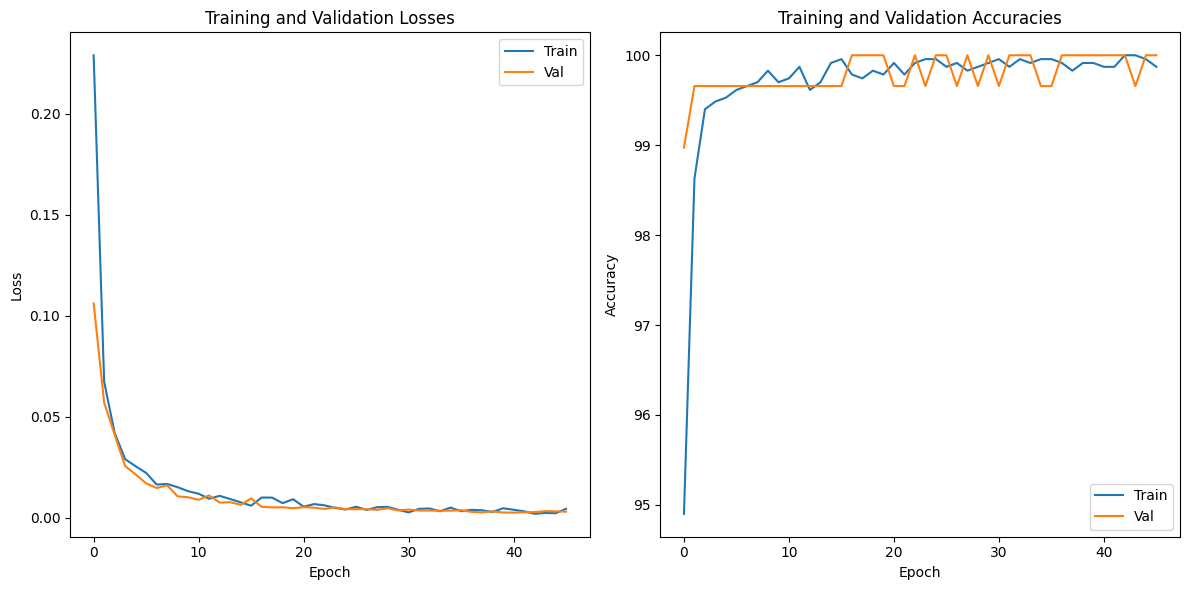

In [17]:
# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')

plt.tight_layout()
plt.show()

In [18]:

# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/eye_detect/eye_or_not_eye1.pth')

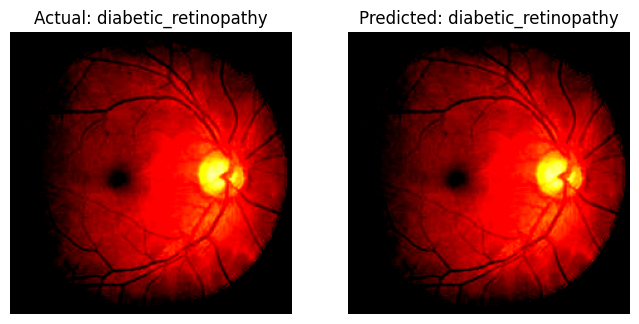

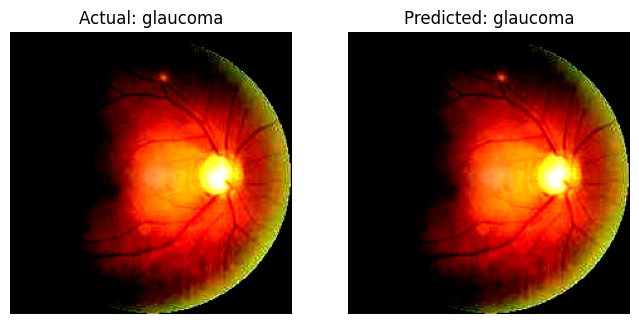

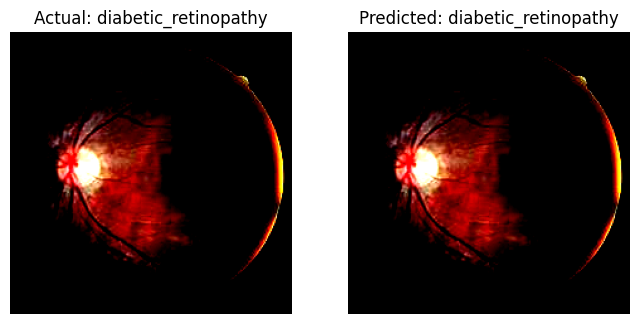

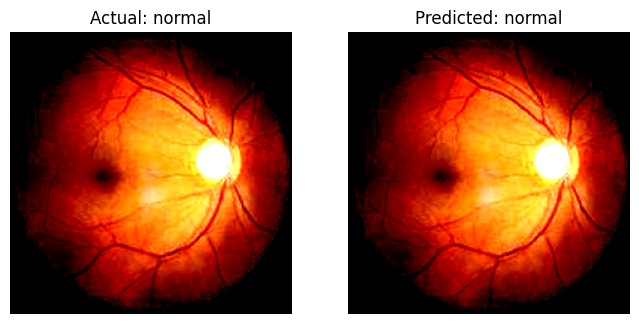

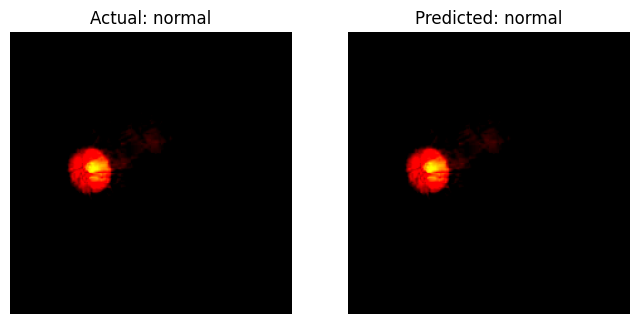

In [ ]:
def plot_actual_vs_predicted(model, test_loader, num_samples=5):
    model.eval()
    class_labels = list(train_data['labels'].unique())
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    sample_indices = np.random.choice(range(len(images)), num_samples, replace=False)

    for i in sample_indices:
        actual_label = class_labels[labels[i].item()]
        predicted_label = class_labels[predicted[i].item()]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()

plot_actual_vs_predicted(model, test_loader)


# Unseen Image

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pretrained VGG model
model = models.vgg16(pretrained=False)
num_classes = len(train_data['labels'].unique())
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Load the state_dict
state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/eye_detect/eye_or_not_eye.pth')  # Update with your model's path

# Remove the 'base_model.' prefix from state_dict keys
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('base_model.', '')  # remove 'base_model.' prefix
    new_state_dict[name] = v

# Load the modified state_dict
model.load_state_dict(new_state_dict)
model = model.to(device)
model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:

# Define the image transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

def predict(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

In [ ]:
import random
# class_names = {
#     0: 'diabetic_retinopathy',
#     1: 'normal',
#     2: 'cataract'
# }
class_names = {
    0: 'not_eye',
    1: 'eye'
}
unseen_images_dir = '/content/drive/My Drive/Colab Notebooks/data/dataset_resized'  # Update with your directory path

class_images = {class_name: [] for class_name in class_names.values()}

for root, dirs, files in os.walk(unseen_images_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            # Assuming the class name is part of the file name or directory name
            for class_name in class_names.values():
                if class_name in image_path:  # Modify this condition based on your file naming convention
                    class_images[class_name].append(image_path)
                    break

for class_name in class_names.values():
    print(f"\nProcessing images for class: {class_name}")
    for image_path in class_images[class_name]:
        prediction = predict(image_path)
        predicted_class_name = class_names[prediction]
        filename = os.path.basename(image_path)
        print(f"Image: {filename} | Predicted Class: {predicted_class_name}")


Processing images for class: not_eye
Image: not_eye_557.jpg | Predicted Class: not_eye
Image: not_eye_566.jpg | Predicted Class: not_eye
Image: not_eye_546.jpg | Predicted Class: not_eye
Image: not_eye_542.jpg | Predicted Class: not_eye
Image: not_eye_562.jpg | Predicted Class: not_eye
Image: not_eye_565.jpg | Predicted Class: not_eye
Image: not_eye_555.jpg | Predicted Class: not_eye
Image: not_eye_561.jpg | Predicted Class: not_eye
Image: not_eye_574.jpg | Predicted Class: not_eye
Image: not_eye_573.jpg | Predicted Class: not_eye
Image: not_eye_577.jpg | Predicted Class: not_eye
Image: not_eye_606.jpg | Predicted Class: not_eye
Image: not_eye_576.jpg | Predicted Class: not_eye
Image: not_eye_605.jpg | Predicted Class: not_eye
Image: not_eye_596.jpg | Predicted Class: not_eye
Image: not_eye_584.jpg | Predicted Class: not_eye
Image: not_eye_583.jpg | Predicted Class: not_eye
Image: not_eye_591.jpg | Predicted Class: not_eye
Image: not_eye_581.jpg | Predicted Class: not_eye
Image: not_e

In [ ]:
unseen_images_dir = '/content/drive/My Drive/Colab Notebooks/test_new'
image_paths = []
class_names = {
    0: 'not_eye',
    1: 'eye'
}
# class_names = {
#     0: 'diabetic_retinopathy',
#     1: 'normal',
#     2: 'cataract'
# }
for root, dirs, files in os.walk(unseen_images_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

random.shuffle(image_paths)

# Placeholder for results
results = []

# Loop through the unseen images and make predictions
for image_path in image_paths:
    prediction = predict(image_path)
    filename = os.path.basename(image_path)
    predicted_class_name = class_names[prediction]
    results.append({
        'Image': filename,
        'Predicted Class': prediction,
        'Predicted Class Name': predicted_class_name
    })

# Convert results to DataFrame
df = pd.DataFrame(results)

# Save DataFrame to CSV
df.to_csv('/content/drive/My Drive/Colab Notebooks/model/predictions_unseen_images_resized_v1.2.csv', index=False)

              precision    recall  f1-score   support

         eye       1.00      1.00      1.00       145
     not_eye       1.00      1.00      1.00       147

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292



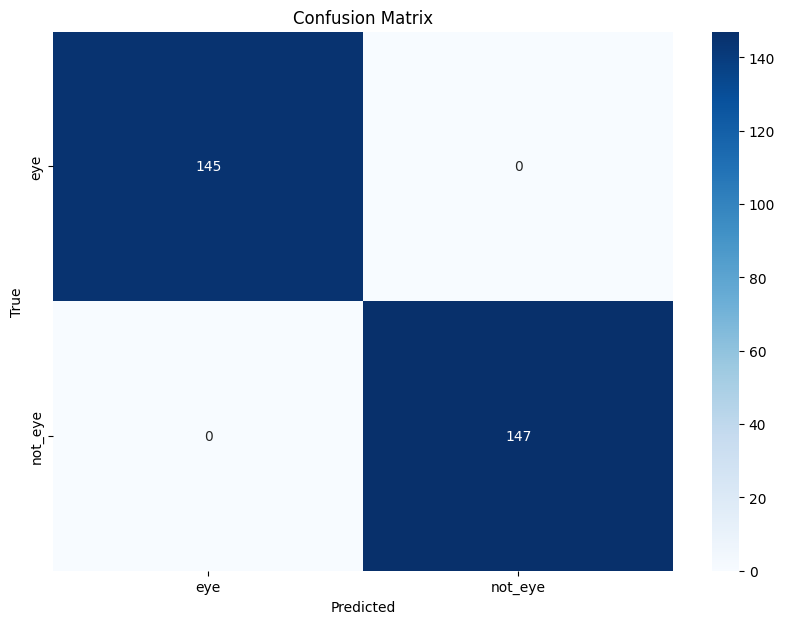

In [19]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device
model.to(device)
model.eval()

true_labels = []
pred_labels = []

# Move images and labels to the same device as the model
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate classification report
class_names = ['eye', 'not_eye']
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Compute confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
